In [1]:
from environment import ContextualEnvironment
from policies import KLUCBSegmentPolicy, RandomPolicy, ExploreThenCommitSegmentPolicy, EpsilonGreedySegmentPolicy, TSSegmentPolicy, LinearTSPolicy
import argparse
import json
import logging
import numpy as np
import pandas as pd
import time
from main import *

In [2]:
users_path = "data/user_features.csv"
users_df = pd.read_csv(users_path)

playlists_path = "data/playlist_features.csv"
playlists_df = pd.read_csv(playlists_path)


In [3]:
n_users = len(users_df)
n_playlists = len(playlists_df)
n_recos = 12

print_every = 10

In [4]:
user_features = np.array(users_df.drop(["segment"], axis = 1))
user_features = np.concatenate([user_features, np.ones((n_users,1))], axis = 1)
playlist_features = np.array(playlists_df)

In [5]:
user_segment = np.array(users_df.segment)

In [6]:
cont_env = ContextualEnvironment(user_features, playlist_features, user_segment, n_recos)

In [7]:
policies_name = "random,etc-seg-explore,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,kl-ucb-seg,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic".split(",")
policies = set_policies(policies_name, user_segment, user_features, n_playlists)
n_policies = len(policies)

n_users_per_round = 20000
n_rounds = 100
overall_rewards = np.zeros((n_policies, n_rounds))
overall_optimal_reward = np.zeros(n_rounds)

/Users/christophbartmann/Library/Mobile Documents/com~apple~CloudDocs/New Macbook/Data Science/Design of Experiment/Exercise 2/carousel_reproduction/online_logistic_regression.py:26: RuntimeWarning: invalid value encountered in reciprocal
  self.w = np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)


In [8]:
l_init = 3
n_recos = 12

In [9]:
for k in range(6,7):
    print("Run: %d"%(k))
    cont_env = ContextualEnvironment(user_features, playlist_features, user_segment, n_recos)    
    #print("STARTING SIMULATIONS")
    #print("for %d rounds, with %d users per round (randomly drawn with replacement)\n \n" % (n_rounds, n_users_per_round))
    start_time = time.time()
    for i in range(n_rounds):
        # Select batch of n_users_per_round users
        user_ids = np.random.choice(range(n_users), n_users_per_round)
        overall_optimal_reward[i] = np.take(cont_env.th_rewards, user_ids).sum()
        # Iterate over all policies
        for j in range(n_policies):
            # Compute n_recos recommendations
            recos = policies[j].recommend_to_users_batch(user_ids, n_recos, l_init)
            # Compute rewards
            rewards = cont_env.simulate_batch_users_reward(batch_user_ids= user_ids, batch_recos=recos)
            # Update policy based on rewards
            policies[j].update_policy(user_ids, recos, rewards, l_init)
            overall_rewards[j,i] = rewards.sum()
        # Print info
        #if i == 0 or (i+1) % print_every == 0 or i+1 == n_rounds:
        #    print("Round: %d/%d. Elapsed time: %f sec." % (i+1, n_rounds, time.time() - start_time))
        #    print("Cumulative regrets: \n%s \n" % "\n".join(["	%s : %s" % (policies_name[j], str(np.sum(overall_optimal_reward - overall_rewards[j]))) for j in range(n_policies)]))

    output_path = 'reproducibility_exp/New_enviro_results_%d.json'%(k)
    print("Saving cumulative regrets in %s" % output_path)
    cumulative_regrets = {policies_name[j] : list(np.cumsum(overall_optimal_reward - overall_rewards[j])) for j in range(n_policies)}
    with open(output_path, 'w') as fp:
        json.dump(cumulative_regrets, fp)


Run: 6


/Users/christophbartmann/Library/Mobile Documents/com~apple~CloudDocs/New Macbook/Data Science/Design of Experiment/Exercise 2/carousel_reproduction/online_logistic_regression.py:47: RuntimeWarning: invalid value encountered in reciprocal
  P = (1 + np.exp(1 - X.dot(self.m))) ** (-1)


KeyboardInterrupt: 

In [2]:
all ={}
mean ={}
std = {}
data_path = 'reproducibility_exp/completly_new/results_0.json'

with open(data_path, 'r') as fp:
    cumulative_regrets = json.load(fp)
for k,v in cumulative_regrets.items():
    all[k] = list()
    mean[k] = list()
    std[k] = list()

for k in range(3):
    output_path = 'reproducibility_exp/completly_new/results_%d.json'%(k)
    with open(output_path, 'r') as fp:
        cumulative_regrets = json.load(fp)

        for k,v in cumulative_regrets.items():
            all[k].append(np.array(v))

            


    


    

In [3]:
for i in all.keys():
    for j in range(len(all[i][0])):
        intermediate = list()
        for k in range(len(all[i])):
            intermediate.append(all[i][k][j])

        mean[i].append(np.mean(intermediate))
        std[i].append(np.std(intermediate))

        #mean[i].append(np.mean(all[i][0][j], all[i][1][j], all[i][2][j], all[i][3][j], all[i][4][j]))


In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style(style='darkgrid')

In [5]:
import matplotlib.colors as mcolors
pos_col = mcolors.TABLEAU_COLORS.keys()

In [17]:
list(mean.keys())[0]

'random'

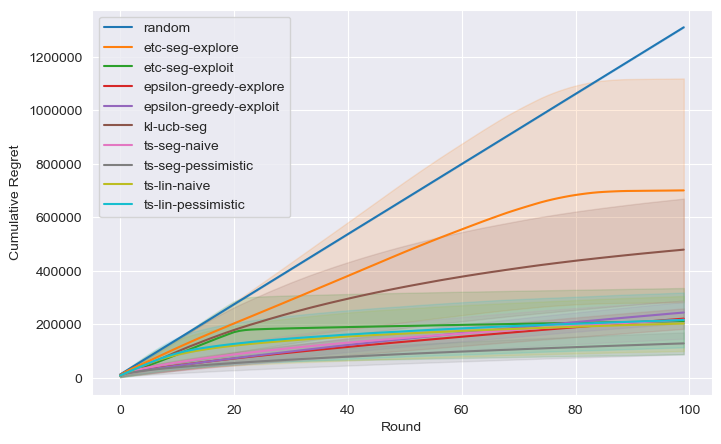

In [13]:

fig, ax = plt.subplots(figsize=(8,5))
for i in range(len(mean.keys())):
    sns.lineplot(data = np.array(mean[list(mean.keys())[i]]), label = list(mean.keys())[i], color=list(pos_col)[i])
    plt.fill_between(range(len(mean[list(mean.keys())[i]])), np.array(mean[list(mean.keys())[i]])-np.array(std[list(mean.keys())[i]]), np.array(mean[list(mean.keys())[i]])+np.array(std[list(mean.keys())[i]]), alpha =0.15, color=list(pos_col)[i])
ax.ticklabel_format(style='plain')
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.show()